In [1]:
# Let's start with some standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [3]:
# Downloading and unzipping dataset
# Only need to run once

#!cd data/ && kaggle competitions download -c titanic
#!cd data/ && unzip titanic.zip

In [6]:
# Let's load the data and take a first look
df = pd.read_csv("data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
# Our primary cross validation method will be K-fold CV
# Since our dataset and models will be small, we'll have resources to train several models to estimate model variance
# Because of this, we won't have an individual val set - we're safe to do EDA on the whole given dataset

In [7]:
# Let's look at a summary of the data
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# Get a list of features
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
# Get total number of passengers
N = len(df)

In [18]:
# First, let's look at passenger id
# It appears like it might just be a linear increment
print(df.PassengerId.head(100))

# Let's confirm
for n in range(N):
    assert((n+1) == df.PassengerId[n])
# Looks like we're good to go

0       1
1       2
2       3
3       4
4       5
     ... 
95     96
96     97
97     98
98     99
99    100
Name: PassengerId, Length: 100, dtype: int64


Survived
0    549
1    342
Name: count, dtype: int64


<Axes: xlabel='Survived'>

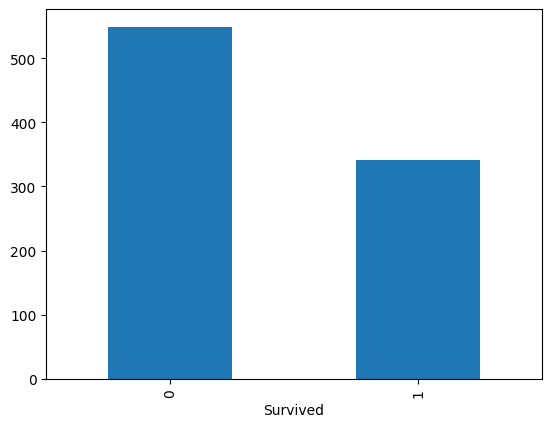

In [56]:
# Next, let's look at the Survived column
# This is our y - the value we're trying to predict
# Let's confirm we're only getting binary values
assert([0,1] in df.Survived.unique())
survived_cnts = df.Survived.value_counts(dropna=False)
print(survived_cnts)
survived_cnts.plot(kind='bar')
# Less than 40% of people in this dataset survived

Pclass
3    491
1    216
2    184
Name: count, dtype: int64


<Axes: xlabel='Pclass'>

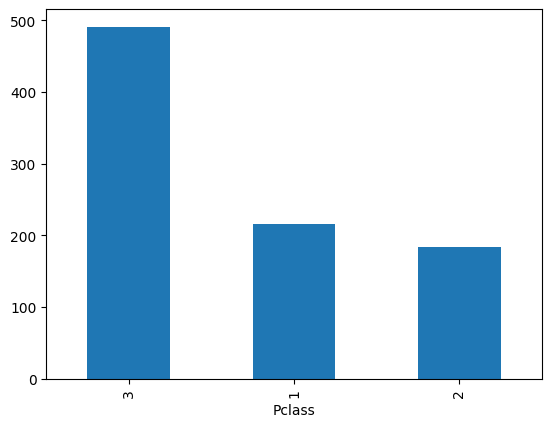

In [58]:
# Next - Pclass, which is the ticket class
# Looks like it's a ternary feature
# When we start doing preprocessing, we need to one-hot encode this
pclass_cnts = df.Pclass.value_counts(dropna=False)
print(pclass_cnts)
pclass_cnts.plot(kind='bar')

In [49]:
# Next, let's look at names
# Confirmed all names are unique
# I will probably not dive too deep into text features until later
assert(df.Name.is_unique)

# Let's get the most words (first names, last names, prefix, suffix, etc.)
from collections import Counter
words = " ".join(df.Name)
name_word_cnts = Counter(words.split())
print(name_word_cnts.most_common(20))

[('Mr.', 517), ('Miss.', 182), ('Mrs.', 125), ('William', 62), ('John', 44), ('Master.', 40), ('Henry', 33), ('James', 24), ('Charles', 23), ('George', 22), ('Thomas', 21), ('Edward', 18), ('Joseph', 16), ('Johan', 15), ('Frederick', 15), ('Mary', 13), ('Richard', 13), ('Samuel', 13), ('Arthur', 13), ('Alfred', 12)]


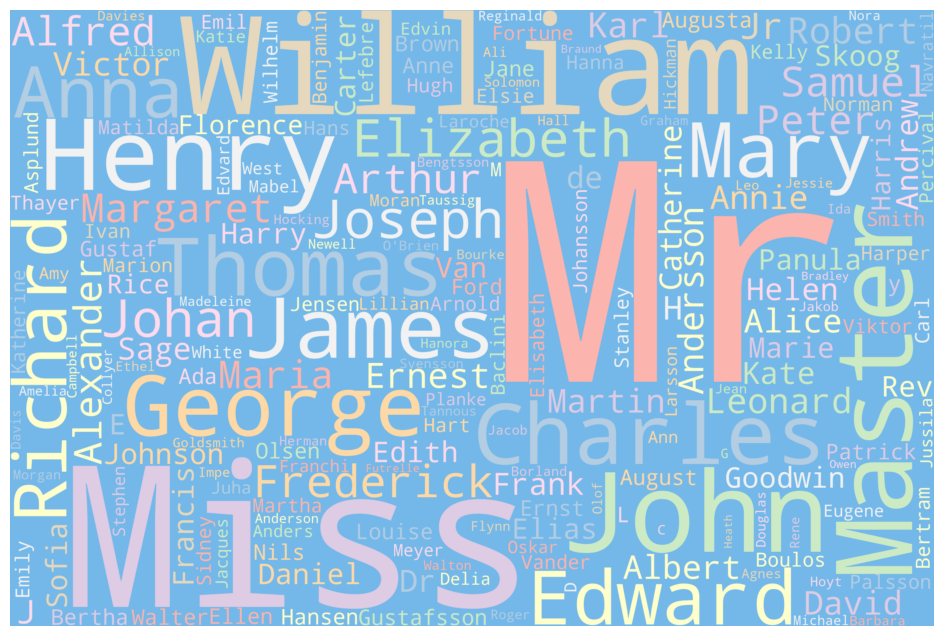

In [50]:
# Let's create a word cloud with all of the words in the names column
# from wordcloud import WordCloud, STOPWORDS
# wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='#73B8E9', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(words)
# plt.figure(figsize=(12, 8))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

<Axes: xlabel='Sex'>

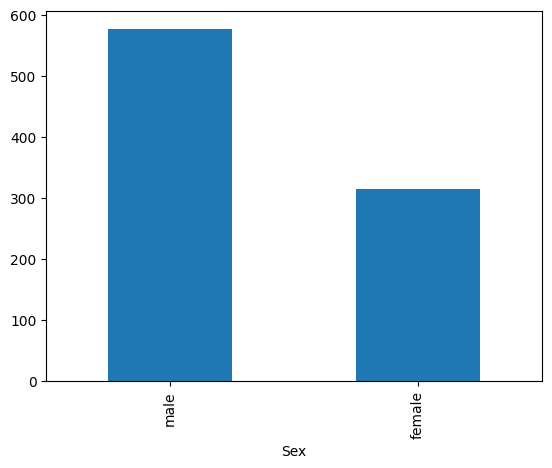

In [59]:
# Next is Sex
# Let's confirm if it's binary
sex_cnts = df.Sex.value_counts(dropna=False)
sex_cnts.plot(kind='bar')
# We'll encode these into a binary 0/1 feature later

Age
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: count, Length: 88, dtype: int64


<Axes: >

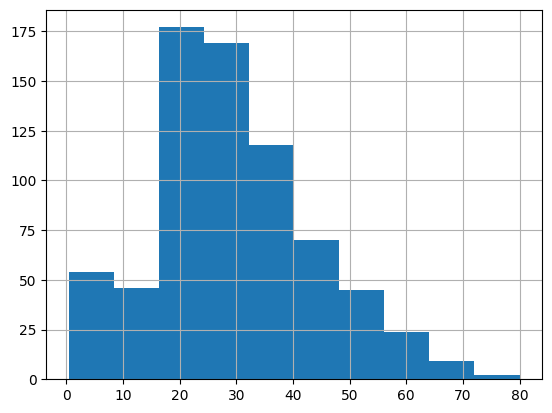

In [70]:
age_cnts = df.Age.value_counts()
print(age_cnts)
# Interestingly, we have fractional ages here
df.Age.hist()
# May be a skewed normal distribution?
# May want to create feature bins for age groups (baby, child, adult, etc.)

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64


<Axes: >

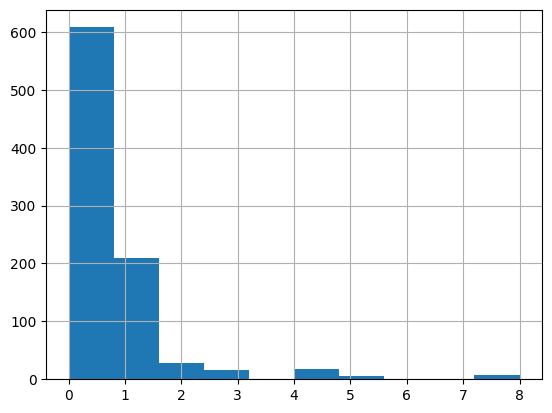

In [73]:
# Next is number of siblings / spouses on-board
sibsp_cnts = df.SibSp.value_counts()
print(sibsp_cnts)
df.SibSp.hist()
# Could split this into a binary feature - i.e. are you in a family on the Titanic?
# Another thing to note - we seem to have five folks in a family of 5 (are they in the same family?) and 7 folks in a family of 8.
# But one of the eight isn't on the list?
# Maybe it's in the test set
# This feature MAY cause overfitting since we're going to edge of the range for this feature

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64


<Axes: >

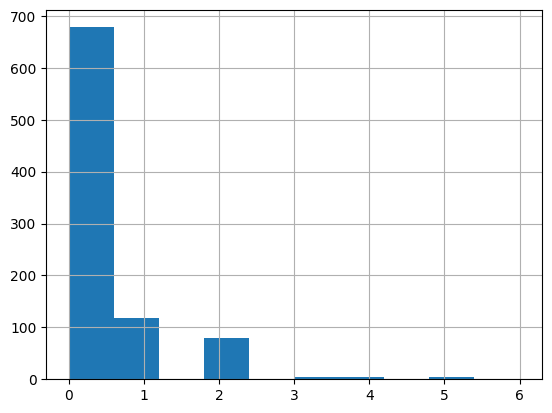

In [79]:
# Next is num parents / children on Titanic
print(df.Parch.value_counts())
df.Parch.hist()
# Most folks don't have parents or children
# The most common non-zero value is 1
# Could split this up into categorical features? 
# Maybe just 0, 1, 2, and 2+?

[('PC', 60), ('C.A.', 27), ('STON/O', 12), ('2.', 12), ('A/5', 10), ('W./C.', 9), ('SOTON/O.Q.', 8), ('CA.', 8), ('A/5.', 7), ('347082', 7), ('1601', 7), ('SOTON/OQ', 7), ('2343', 7), ('STON/O2.', 6), ('3101295', 6), ('CA', 6), ('2144', 6), ('347088', 6), ('382652', 5), ('S.O.C.', 5), ('14879', 5), ('C', 5), ('SC/PARIS', 5), ('F.C.C.', 5), ('349909', 4), ('347077', 4), ('19950', 4), ('SC/Paris', 4), ('6608', 4), ('4133', 4), ('LINE', 4), ('113781', 4), ('17421', 4), ('17757', 4), ('113760', 4), ('2666', 4), ('347742', 3), ('PP', 3), ('2123', 3), ('A/4.', 3)]
count    8.870000e+02
mean     2.983284e+05
std      6.576144e+05
min      3.000000e+00
25%      1.487900e+04
50%      1.122770e+05
75%      3.470820e+05
max      3.101317e+06
dtype: float64


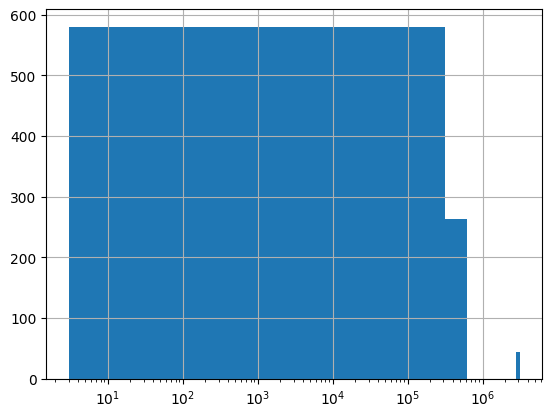

In [89]:
# Next is ticket id
# This seems more like a string?
# Let's extract the most common words
df.Ticket.head()
ticket_words_list = " ".join(df.Ticket).split()
ticket_word_cnts = Counter(ticket_words_list)
print(ticket_word_cnts.most_common(40))
# Surpringly some of these are words, but some are numbers too - what's the relation? Do families share ticket numbers?
# Let's grab the numbers and make a histogram
ticket_nums_series = pd.Series([int(n) for n in ticket_words_list if n.isnumeric()])
plt.xscale('log')
ticket_nums_series.hist()
print(ticket_nums_series.describe())
# Looks to mostly look like a linear increment with some values missing

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64
Fare
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: count, Length: 248, dtype: int64


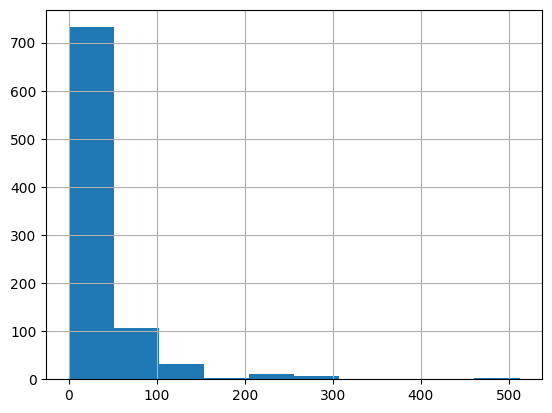

In [98]:
# Next let's look at fare
print(df.Fare.describe())
df.Fare.hist()
# Looks like some people got in for free!
print(df.Fare.value_counts())
# Might be good to bin these values - there are defintely some standard price values

In [116]:
#'Cabin', 'Embarked'
# Almost done with univariate EDA - let's look at cabin numbers next
print(df.Cabin.value_counts())
print(df.Cabin.describe())
# What are these letters? Floor numbers? Could be correlated with class
# Looks like we also have some missing values in here
print(f"Number of non-null values: {len(df.Cabin.dropna())} / {len(df.Cabin)}")
# We can probably include an is nan feature for missing cabin numbers
text = " ".join(df.Cabin.dropna())
Counter(c for c in text.lower() if c.isalpha())

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64
count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object
Number of non-null values: 204 / 891


Counter({'c': 71, 'b': 64, 'd': 34, 'e': 33, 'a': 15, 'f': 13, 'g': 7, 't': 1})

In [ ]:
# And lastly - embarked, which encodes where the port the 